 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:7891/notebooks/cv_parker/miniplaces/miniplaces_parker.ipynb#Download-+-Preprocess-Data" data-toc-modified-id="Download-+-Preprocess-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download + Preprocess Data</a></span><ul class="toc-item"><li><span><a href="http://localhost:7891/notebooks/cv_parker/miniplaces/miniplaces_parker.ipynb#Download" data-toc-modified-id="Download-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download</a></span></li><li><span><a href="http://localhost:7891/notebooks/cv_parker/miniplaces/miniplaces_parker.ipynb#Preprocess" data-toc-modified-id="Preprocess-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Preprocess</a></span></li></ul></li><li><span><a href="http://localhost:7891/notebooks/cv_parker/miniplaces/miniplaces_parker.ipynb#Models" data-toc-modified-id="Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="http://localhost:7891/notebooks/cv_parker/miniplaces/miniplaces_parker.ipynb#~Inception-v4" data-toc-modified-id="~Inception-v4-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>~Inception v4</a></span></li><li><span><a href="http://localhost:7891/notebooks/cv_parker/miniplaces/miniplaces_parker.ipynb#VGG" data-toc-modified-id="VGG-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>VGG</a></span></li></ul></li><li><span><a href="http://localhost:7891/notebooks/cv_parker/miniplaces/miniplaces_parker.ipynb#Model-Comparison" data-toc-modified-id="Model-Comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Comparison</a></span></li></ul></div>

From [this class][class] (look at more of their notes later)

Design principles
* Reduce filter sizes (except possibly at the lowest layer), factorize filters aggressively
* Use 1x1 convolutions to reduce and expand the number of feature maps judiciously
* Use skip connections and/or create multiple paths through the network 

What else?
* Training tricks and details: initialization, regularization, normalization
* Training data augmentation
* Averaging classifier outputs over multiple crops/flips
* Ensembles of networks

[class]: http://slazebni.cs.illinois.edu/spring17/

Submit results [here][submission] with team code: **KknPS9LrSKwM2cFXe9T2**

See the leaderboard [here][lb].

[submission]: http://miniplaces.csail.mit.edu/submit.php
[lb]: http://miniplaces.csail.mit.edu/leaderboard.php

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tnrange
import time
import os
import sys
sys.path = ['/scratch/nhunt/cv_parker/scripts'] + sys.path
from utils import tf_init, get_next_run_num, load_data, output_file
from layers import ConvLayer, MaxPoolLayer, AvgPoolLayer, BranchedLayer, MergeLayer, LayerModule, FlattenLayer, DenseLayer, GlobalAvgPoolLayer
from models import CNN, BaseNN

%matplotlib inline
config = tf_init()

In [12]:
train_inputs, train_labels, val_inputs, val_labels, test_inputs = load_data('miniplaces')
n_classes = len(np.unique(train_labels))

# Download + Preprocess Data

We end up with this file structure folder after first downloading everything:

development_kit
 * README
 * ...

data
 * labels
    * categories.txt
    * object_categories.txt
    * train.txt
    * val.txt
 * images
     * train
         * a
             * abbey
             * airport_terminal
             * ...
         * b
         * ...
     * val
     * test
 * objects
     * train
         * a
             * abbey
             * airport_terminal
             * ...
         * b
         * ...
     * val

The train images are stored in directories that correspond to their scene labels. All of the val and test images are stored directly in their directory. The labels for the val images (and for the test ones, for easier access) are in `development_kit/val.txt` and `/train.txt`.

All of the images are .jpg files. The images have been resized to 128x128 to make the challenge easier (computationally; it may be harder in terms of achieving the same accuracy).

The object notations are a special file that tells you the name of the image to which they correspond, where that image is (which folder), and then have bounding polygons (as a series of points) for the objects in the image, with classes for the objects. There are 3502 train images with object annotations and 371 validation images.

**Read the README to get a better idea of the data before continuing!**

## Download

In [13]:
%%bash
wget -q http://6.869.csail.mit.edu/fa17/miniplaces/development_kit.tar.gz
tar -xzf development_kit.tar.gz
rm development_kit.tar.gz

mkdir -p data/labels
mv development_kit/data/* data/labels
rm -r development_kit/data

cd data
wget -q http://6.869.csail.mit.edu/fa17/miniplaces/data.tar.gz
tar -xzf data.tar.gz
rm data.tar.gz

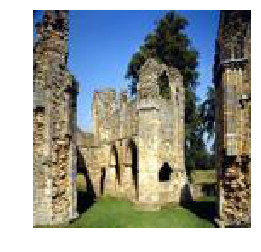

In [14]:
img = plt.imread('data/images/train/a/abbey/00000001.jpg')
plt.imshow(img)
plt.axis('off');

## Preprocess
* Put all train/val/test images in their own array for easy loading (the dataset is small enough that we can load all of them at once)

In [15]:
def save_imgs_together(split, convert_to_float=False, image_path='data/images', labels_path='data/labels/'):
    """
    Reads in all of the images from this split and saves them into a single numpy array.
    This should make the training easier and more efficient.
    :param split: one of train, val, or test; which split of the data to process
                  if split isn't test, the labels will also be saved into a numpy array
    :param convert_to_float: if true, the image array is divided by 255 to conver the data to floats in [0, 1]
    :param image_path: path to the first-level image directories (e.g. a, b, ...)
    :param labels_path: path to the labels data (e.g. train.txt, val.txt)
    """

    img_fnames = ! find $image_path/$split -name *.jpg | sort
    imgs = [plt.imread(img_fname) for img_fname in img_fnames]

    imgs = np.array(imgs)

    if convert_to_float:
        imgs = imgs / 255

    np.save('{}/{}.npy'.format(image_path, split), imgs)

    if split != 'test':  # no labels for test
        labels = pd.read_csv('{}/{}.txt'.format(labels_path, split), sep=' ', header=None, usecols=[1]).iloc[:, 0].values

        assert len(labels) == len(imgs)

        np.save('{}/{}_labels.npy'.format(image_path, split), labels.astype(np.int32))

In [16]:
for split in ['train', 'val', 'test']:
    save_imgs_together(split)

# Models

## ~Inception v4

In [13]:
tf.layers.separable_conv2d

<function tensorflow.python.layers.convolutional.separable_conv2d>

In [16]:
layers = [
    ConvLayer(32, 3),
    GlobalAvgPoolLayer(),
    FlattenLayer()
]

cnn = CNN(layers, models_dir = "/scratch/nhunt/cv_parker/mi", n_classes=n_classes)

# cnn = CNN(n_classes=n_classes, cnn_nodes=(128, 128, 128, 64), dense_nodes=(), batch_size=64, l2_lambda=.001)
cnn.train(train_inputs, train_labels, val_inputs, val_labels, in_notebook=True)

AssertionError: models_dir must be specifed to record a model.

In [ ]:
cnn.score(val_inputs, val_labels)

In [ ]:
cnn = CNN(run_num=52)

In [ ]:
cnn.score(val_inputs, val_labels)

In [ ]:
# cnn.score(val_inputs, val_labels)

In [ ]:
preds = cnn.predict_proba(test_inputs)
output_file(preds)

In [ ]:
prelu()

## VGG

In [19]:
cnn = PretrainedCNN(n_classes=n_classes, dense_nodes=(1024, 1024), batch_size=64, config=config, cnn_module='vgg16',
                   pretrained_weights=False)
cnn.train(train_inputs, train_labels, val_inputs, val_labels, in_notebook=True)

Beginning run 96.


NameError: name 'cnn_modules' is not defined

In [ ]:
# cnn = PretrainedCNN(run_num=20)

In [ ]:
cnn.score(val_inputs, val_labels)

In [ ]:
preds = cnn.predict_proba(val_inputs)
output_file(preds)

# Model Comparison

Adding batch norm: [0.23039998, 0.5126999]

Submitted Models

| Model | Acc@1 | Acc@5 | VAcc@1 | VAcc@5 | Notes | Run # |
|-----|
|  | .2429 | .4776 | 0.2509 | 0.5397 | | ??50-ish |
| | .2691 | .5224 | 0.2900 | 0.5844 | batch norm and l2=.001 | 58 |

In [ ]:
log = pd.read_hdf('models/log.h5', key='default').sort_values('dev_loss')
log.head()